# Plot Raster Map

### Import required packages.

In [1]:
# General imports:
import snowflake.connector
import xarray as xr 
import pandas as pd
import numpy as np
import geopandas as gpd
import yaml
import os
from dotenv import load_dotenv

# Load environment variables.
load_dotenv()

# Cartopy plotting imports:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.img_tiles import OSM


### Connect to snowflake and pull variables of interest.
Note that the access credentials to the snowflake database are not included below. The code should be modified where shown to include the access credentials provided to you. 

In [2]:
# Define the SQL query to get ACD data from Planet for 2020.
sql_query = """
    SELECT
        year,
        lon,
        lat,
        aboveground_carbon_density,
        st_aswkt(boundary) as boundary,
    FROM
        planet.pv_forest_carbon
    WHERE
        year = 2020
    """

# Connect to database using information stored in config file and execute query.
with snowflake.connector.connect(
        account = os.getenv('DB_ACCOUNT'),
        warehouse = os.getenv('DB_WAREHOUSE'),
        database = os.getenv('DB_DATABASE'), 
        user = os.getenv('DB_USERNAME'),
        password = os.getenv('DB_PASSWORD')
) as conn:
    cur = conn.cursor().execute(sql_query)
    df = cur.fetch_pandas_all()


## Option 1: Plot from Pandas Dataframe.

<Axes: xlabel='LON', ylabel='LAT'>

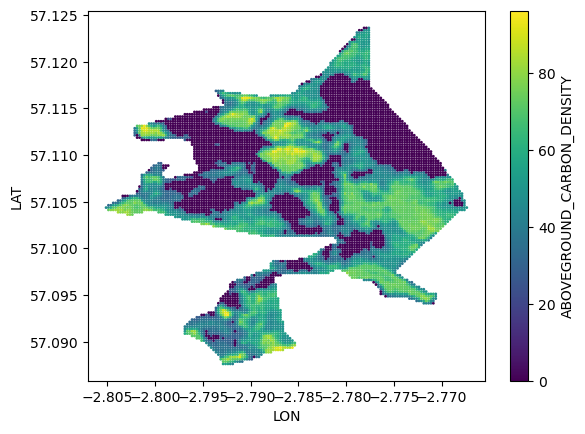

In [3]:
# Plot the data directly from pandas dataframe.
df.plot(x="LON", y="LAT", # Plot latitude on y axis and longitude on x axis.
               kind="scatter", # Set the type of plot to be a scatter plot.
               s=1, # Set the marker size (higher numbers indicate larger markers)
               c="ABOVEGROUND_CARBON_DENSITY", # Set the variable to color the markers by. 
               colormap="viridis", # Set the colormap.
               ) 

## Option 2: Plot from XArray. 

In [4]:
# Set the columns to numeric type.
df[['LAT', 'LON', 'ABOVEGROUND_CARBON_DENSITY']] = df[['LAT', 'LON', 'ABOVEGROUND_CARBON_DENSITY']].apply(pd.to_numeric)

# Set dataframe indices before converting to xarray. 
data_df = df.set_index(['YEAR','LAT', 'LON'])
data_xarr = data_df.to_xarray()

### Plot directly from xarray:

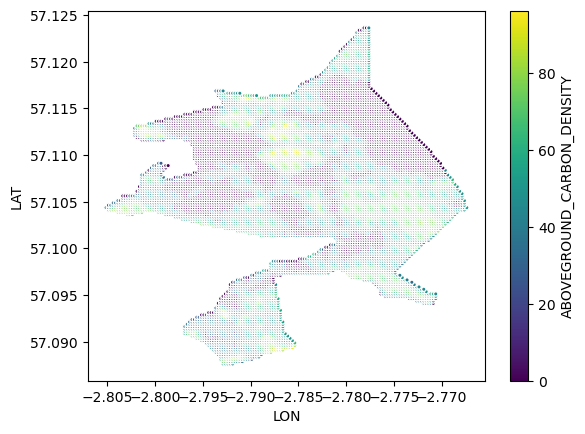

In [5]:
data_xarr.plot.scatter(x="LON", y="LAT", # Plot latitude on y axis and longitude on x axis.
                         hue="ABOVEGROUND_CARBON_DENSITY", # Set the variable to color the markers by. 
                         add_colorbar=True, # Add a colorbar to the plot.
                         s=10, # Set the markersize.
                         cmap="viridis") # Set the colormap.

### Plot from matplotlib:

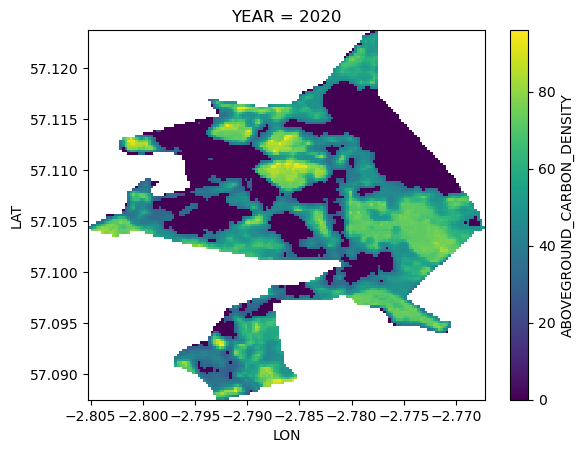

In [6]:
data_xarr['ABOVEGROUND_CARBON_DENSITY'].plot(cmap='viridis')

## Option 3: Plot with basemap from Cartopy.

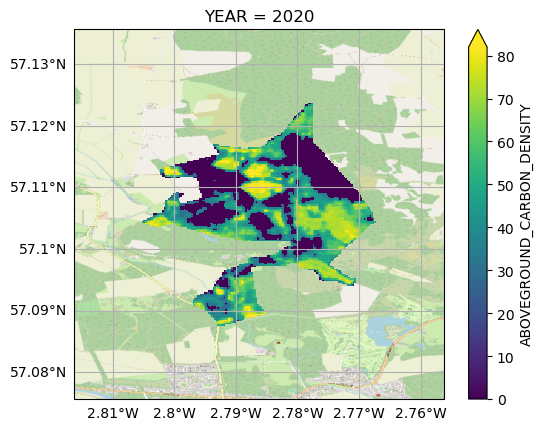

In [7]:
# Select OSM basemap imagery.
imagery = OSM()

# Set up matplotlib figure.
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Calculate the center of the AOI.
lon = data_xarr.coords['LON']
lat = data_xarr.coords['LAT']
lon_center = float(lon.mean())
lat_center = float(lat.mean())

# Set zoom factor (higher values zoom out more).
zoom_out_factor = 0.03 

# Set map frame extent based on AOI and zoom factor.
extent = [lon_center - zoom_out_factor, lon_center + zoom_out_factor,
          lat_center - zoom_out_factor, lat_center + zoom_out_factor]
ax.set_extent(extent, crs=ccrs.PlateCarree())

# Add the basemap imagery to the map.
ax.add_image(imagery, 15)

# Plot the data onto the basemap.
data_xarr['ABOVEGROUND_CARBON_DENSITY'].plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='viridis',
    robust=True
)

# Add gridlines and set labels on the left and bottom only.
gl = ax.gridlines(draw_labels=True)
gl.left_labels = True
gl.right_labels = False
gl.top_labels = False
gl.bottom_labels = True

# Show the plot
plt.show()
